In [1]:
from experiment import Experiment
from params import Params

Using TensorFlow backend.


In [51]:
params = Params()

params.EMBEDDING_DIM            = 24
params.BATCH_SIZE               = 1
params.NUM_SHAPE                = 6
params.NUM_CLASSES              = 4 # (3 shapes + 1 background)
params.NUM_FILTER               = [256, 128]
params.ETH_MEAN_SHIFT_THRESHOLD = 1.5
params.DELTA_VAR                = 0.5
params.DELTA_D                  = 1.5
params.IMG_SIZE                 = 256
params.OUTPUT_SIZE              = 64
params.SEQUENCE_LEN             = 100
params.TRAIN_NUM_SEQ            = 500
params.VAL_NUM_SEQ              = 5
params.TEST_NUM_SEQ             = 10
params.RANDOM_SIZE              = True
params.OPTICAL_FLOW_WEIGHT      = 0
params.BACKBONE                 = 'xception'
params.GITHUB_DIR               = 'C:/Users/yliu60/Documents/GitHub'
params.LEARNING_RATE            = 1e-4
params.EPOCHS                   = 10
params.EPOCHS_PER_SAVE          = 1
params.STEPS_PER_VISUAL         = 1000
params.ROTATE_SHAPES            = False
params.FEATURE_STRING           = f'{params.NUM_SHAPE}_shapes'
params.MODEL_SAVE_DIR           = f'model/{params.FEATURE_STRING}'
params.TRAIN_SET_PATH           = f'dataset/{params.FEATURE_STRING}/train'
params.VAL_SET_PATH             = f'dataset/{params.FEATURE_STRING}/val'
params.TEST_SET_PATH            = f'dataset/{params.FEATURE_STRING}/test'
params.IOU_THRESHOLD            = 0.5
params.MASK_AREA_THRESHOLD      = 20

experiment = Experiment(params)
# experiment.run()
experiment.init_model()

Loading weights from model/6_shapes\9.h5


In [72]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import utils
import visual
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import inference

In [11]:
for j in range(10):
    sequence = experiment.val_datagen.get_sequence()
    frames = experiment.inference_model.track_on_sequence(sequence)
    colors = np.random.rand(1000, 3)
    utils.mkdir_if_missing(f'demo/seq_{j}')
    for i in range(len(frames)):
        frame = frames[i]
        info = sequence[i]
        image = info['image'].astype(np.float32)
        board = np.zeros((256, 256 * 2, 3))
        board[:, :256, :] = image
        half_board = np.zeros((256, 256, 3))
        for target in frame:
            mask = utils.resize_img(target.mask, 256, 256)
            half_board[mask == 1] = colors[target.id, :]
        board[:, 256:, :] = half_board
        board = board * 255
        board = board.astype(np.uint8)
        cv2.imwrite(f'demo/seq_{j}/seq_{j}_track_{i}.png', board)

In [123]:
class PCAViz:
    def __init__(self, verbose:bool=False):
        self.verbose = verbose
        self.PCs = None
        self.e_mu = None
        self.e_std = None
    def recalculate(self, e_flat:np.array):
        cm = np.cov( np.transpose(e_flat) )
        evals, evects = np.linalg.eig( cm )
        order = np.argsort(evals)[::-1]
        evals = evals[order]
        evects = evects[:, order]       
        return evects
    def feed(self, e_flat, mask_flat, out_dims='all', show:bool=False):
        dim = e_flat.shape[0]
        e_flat_original = np.zeros((dim, out_dims))
        idx = mask_flat == 1
        e_flat = e_flat[idx]
        if self.PCs is None:
            if self.verbose:
                print('Reclaculating')
            self.PCs = self.recalculate(e_flat)
            self.e_mu = np.mean( e_flat,0 )
            self.e_std = np.std( e_flat,0 )
        if out_dims is 'all':
            out_dims = self.PCs.shape[0]
        scores_flat = np.matmul( (e_flat-self.e_mu)/self.e_std , self.PCs)
        scores_flat = scores_flat[:, :out_dims]
        mask_flat = np.expand_dims(mask_flat, axis=-1)
        scores_flat = utils.normalize(scores_flat)
        e_flat_original[idx] = scores_flat
        return e_flat_original

In [132]:
class_num     = params.NUM_CLASSES
embedding_dim = params.EMBEDDING_DIM
image_size    = params.IMG_SIZE
OS            = params.OUTPUT_SIZE
nD            = params.EMBEDDING_DIM
boards = []
video_name = 'video/continuous_emb.avi'
pcaviz = PCAViz()
# sequence = experiment.val_datagen.get_sequence()
for i in range(len(sequence) - 1):
    prev_image_info = sequence[i]
    image_info = sequence[i+1]
    board = np.zeros((image_size*2, image_size*2, 3))
    prev_image = prev_image_info['image']
    image = image_info['image']
    board[:image_size, :image_size, :] = prev_image
    board[:image_size, image_size:, :] = image
    x, _ = utils.prep_double_frame(prev_image_info, image_info)
    combined_embedding_pred, combined_class_mask_pred_int, cluster_all_class = experiment.inference_model.segment(x)
    width, height, _ = combined_embedding_pred.shape
    embedding_pred_flat = np.reshape(combined_embedding_pred, (-1, nD))
    mask_flat = np.reshape(combined_class_mask_pred_int, (-1,))
    masked_emb_flat = pcaviz.feed(embedding_pred_flat, mask_flat > 0, 3)
    masked_emb = np.reshape(masked_emb_flat, (width, height, 3))
    front_masked_emb = np.zeros((OS, OS*2, 3))
    front_masked_emb[:, :OS, :] = masked_emb[:, OS*2:OS*3, :]
    front_masked_emb[:, OS:, :] = masked_emb[:, :OS, :]
    front_masked_emb = utils.resize_img(front_masked_emb, image_size, image_size * 2)
    board[image_size:, :, :] = front_masked_emb
    board = visual.float_to_uint8(board)
    boards.append(board)
visual.imgs_to_video(boards, video_name, fps)

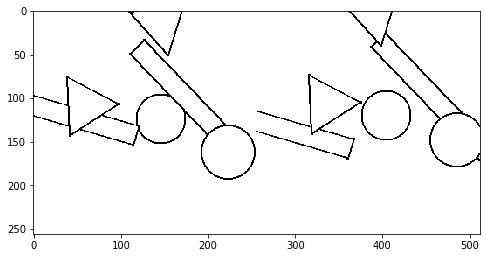

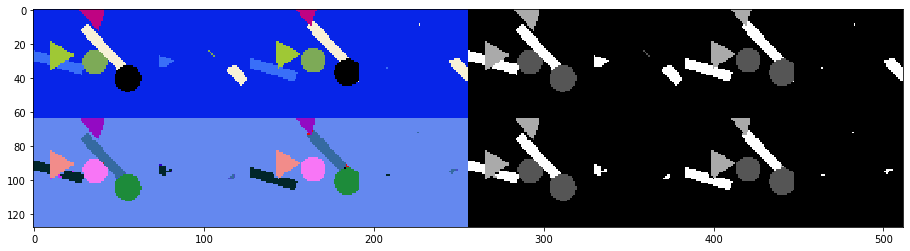

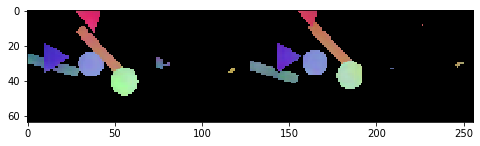

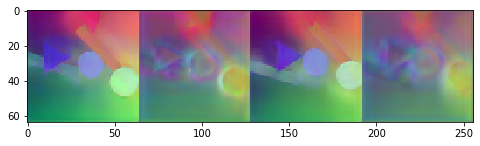

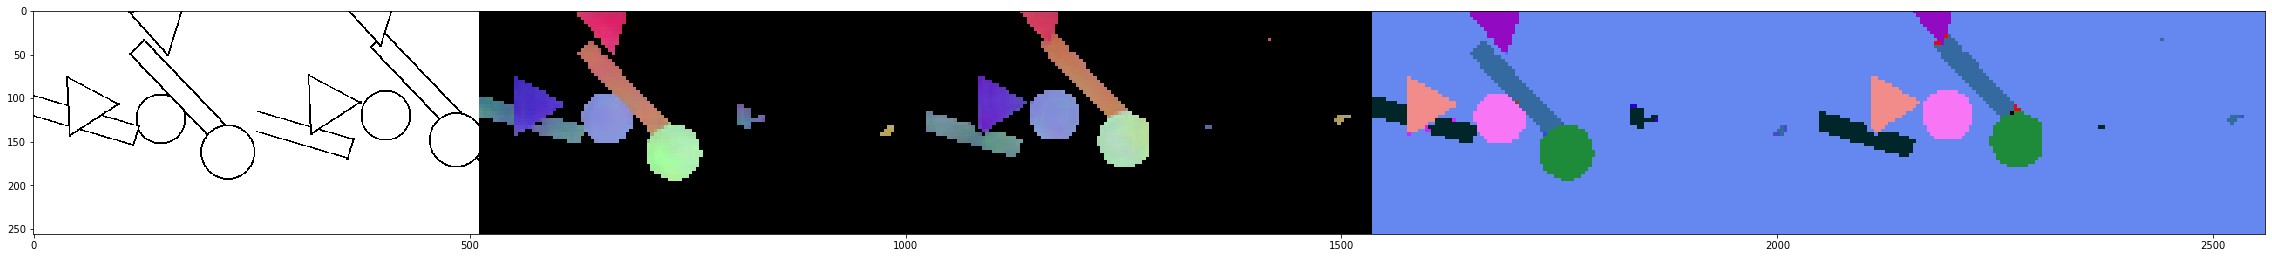

In [155]:
import importlib
importlib.reload(visual)
visual.eval_pair(experiment.model, sequence[0:2], params)

In [ ]:
import eval

sequence = experiment.val_data_loader.get_next_sequence()
evaluator = eval.MaskTrackEvaluator(iou_threshold=experiment.params.IOU_THRESHOLD)
gt_sequence = evaluator.gen_target_sequence(sequence)
tracks = experiment.inference_model.track_on_sequence(sequence)

In [ ]:
dg = SequenceDataGenerator(
    num_shape    = params.NUM_SHAPE, 
    image_size   = params.IMG_SIZE,
    sequence_len = params.SEQUENCE_LEN)
sequence = dg.get_sequence()
image_info = sequence[0]
prev_image_info = sequence[1]
x, y = prep_double_frame(image_info, prev_image_info, params)
outputs = np.random.rand(1, 64, 64, 34)

In [ ]:
outputs = model.predict(x)

In [ ]:
K.clear_session()

y_true = tf.placeholder(dtype = tf.float32, shape = (1, 32, 32, 6))
y_pred = tf.placeholder(dtype = tf.float32, shape = (1, 32, 32, 34))

delta_var     = params.DELTA_VAR
delta_d       = params.DELTA_D
class_num     = params.NUM_CLASSES
embedding_dim = params.EMBEDDING_DIM

# unpack ground truth contents
class_mask_gt      = y_true[:, :, :, 0]
prev_class_mask_gt = y_true[:, :, :, 1]
identity_mask      = y_true[:, :, :, 2]
prev_identity_mask = y_true[:, :, :, 3]
optical_flow_gt    = y_true[:, :, :, 4:5]

# y_pred
class_mask_pred      = y_pred[:, :, :, :class_num]
prev_class_mask_pred = y_pred[:, :, :, class_num:(class_num * 2)]
instance_emb         = y_pred[:, :, :, (class_num * 2):(class_num * 2 + embedding_dim)]
prev_instance_emb    = y_pred[:, :, :, (class_num * 2 + embedding_dim):(class_num * 2 + embedding_dim * 2)]
optical_flow_pred    = y_pred[:, :, :, (class_num * 2 + embedding_dim * 2):]

# flatten and combine
# --identity mask gt
identity_mask_flat            = K.flatten(identity_mask)
prev_identity_mask_flat       = K.flatten(prev_identity_mask)
combined_identity_mask_flat   = tf.concat((identity_mask_flat, prev_identity_mask_flat), axis=0)
# --instance embedding pred
instance_emb_flat             = tf.reshape(instance_emb, shape=(-1, embedding_dim))
prev_instance_emb_flat        = tf.reshape(prev_instance_emb, shape=(-1, embedding_dim))
combined_instance_emb_flat    = tf.concat((instance_emb_flat, prev_instance_emb_flat), axis=0)
# --class mask gt
class_mask_gt_flat            = K.flatten(class_mask_gt)
prev_class_mask_gt_flat       = K.flatten(prev_class_mask_gt)
combined_class_mask_gt_flat   = tf.concat((class_mask_gt_flat, prev_class_mask_gt_flat), axis=0)
# --class mask pred
class_mask_pred_flat          = tf.reshape(class_mask_pred, shape=(-1, class_num))
prev_class_mask_pred_flat     = tf.reshape(prev_class_mask_pred, shape=(-1, class_num))
combined_class_mask_pred_flat = tf.concat((class_mask_pred_flat, prev_class_mask_pred_flat), axis=0)

# get number of pixels and clusters (without background)
num_cluster = tf.reduce_max(combined_identity_mask_flat)
num_cluster = tf.cast(num_cluster, tf.int32)

# cast masks into tf.int32 for one-hot encoding
combined_identity_mask_flat = tf.cast(combined_identity_mask_flat, tf.int32)
combined_class_mask_gt_flat = tf.cast(combined_class_mask_gt_flat, tf.int32)

# one-hot encoding
combined_identity_mask_flat -= 1
combined_identity_mask_flat_one_hot = tf.one_hot(combined_identity_mask_flat, num_cluster)
conbined_class_mask_gt_flat_one_hot = tf.one_hot(combined_class_mask_gt_flat, class_num)

# ignore background pixels
non_background_idx                  = tf.greater(combined_identity_mask_flat, -1)
combined_instance_emb_flat          = tf.boolean_mask(combined_instance_emb_flat, non_background_idx)
combined_identity_mask_flat         = tf.boolean_mask(combined_identity_mask_flat, non_background_idx)
combined_identity_mask_flat_one_hot = tf.boolean_mask(combined_identity_mask_flat_one_hot, non_background_idx)
combined_class_mask_gt_flat         = tf.boolean_mask(combined_class_mask_gt_flat, non_background_idx)

# center count
combined_identity_mask_flat_one_hot = tf.cast(combined_identity_mask_flat_one_hot, tf.float32)
center_count = tf.reduce_sum(combined_identity_mask_flat_one_hot, axis=0)
# add a small number to avoid division by zero

# variance term
embedding_sum_by_instance = tf.matmul(
    tf.transpose(combined_instance_emb_flat), combined_identity_mask_flat_one_hot)
centers = tf.math.divide_no_nan(embedding_sum_by_instance, center_count)
gathered_center = tf.gather(centers, combined_identity_mask_flat, axis=1)
gathered_center_count = tf.gather(center_count, combined_identity_mask_flat)
combined_emb_t = tf.transpose(combined_instance_emb_flat)
var_dist = tf.norm(combined_emb_t - gathered_center, ord=1, axis=0) - delta_var
# changed from soft hinge loss to hard cutoff
var_dist_pos = tf.square(tf.maximum(var_dist, 0))
var_dist_by_instance = tf.math.divide_no_nan(var_dist_pos, gathered_center_count)
num_cluster = tf.cast(num_cluster, tf.float32)
variance_term = tf.math.divide_no_nan(
    tf.reduce_sum(var_dist_by_instance),
    tf.cast(num_cluster, tf.float32))

# get instance to class mapping
class_mask_gt = tf.expand_dims(class_mask_gt, axis=-1)
# multiply classification with one hot flat identity mask
combined_class_mask_gt_flat = tf.cast(combined_class_mask_gt_flat, tf.float32)
combined_class_mask_gt_flat = tf.expand_dims(combined_class_mask_gt_flat, 1)
filtered_class = tf.multiply(combined_identity_mask_flat_one_hot, combined_class_mask_gt_flat)
# shrink to a 1 by num_of_cluster vector to map instance to class;
# by reduce_max, any class other than 0 (background) stands out
instance_to_class = tf.reduce_max(filtered_class, axis = [0])

def distance_true_fn(num_cluster_by_class, centers_by_class):
    centers_row_buffer = tf.ones((embedding_dim, num_cluster_by_class, num_cluster_by_class))
    centers_by_class = tf.expand_dims(centers_by_class, axis=2)
    centers_row = tf.multiply(centers_row_buffer, centers_by_class)
    centers_col = tf.transpose(centers_row, perm=[0, 2, 1])
    dist_matrix = centers_row - centers_col
    idx2 = tf.ones((num_cluster_by_class, num_cluster_by_class))
    diag = tf.ones((1, num_cluster_by_class))
    diag = tf.reshape(diag, [-1])
    idx2 = idx2 - tf.diag(diag)
    idx2 = tf.cast(idx2, tf.bool)
    idx2 = K.flatten(idx2)
    dist_matrix = tf.reshape(dist_matrix, [embedding_dim, -1])
    dist_matrix = tf.transpose(dist_matrix)
    sampled_dist = tf.boolean_mask(dist_matrix, idx2)
    distance_term = tf.square(tf.maximum(
        2 * delta_d - tf.norm(sampled_dist, ord=1, axis=1), 0))
    total_cluster_pair = num_cluster_by_class * (num_cluster_by_class - 1) + 1
    total_cluster_pair = tf.cast(total_cluster_pair, tf.float32)
    distance_term = tf.math.divide_no_nan(tf.reduce_sum(distance_term), total_cluster_pair)
    return distance_term


def distance_false_fn():
    return 0.0


distance_term_total = 0.0
# center distance term
for i in range(class_num-1):
    class_idx = tf.equal(instance_to_class, i+1)
    centers_transpose = tf.transpose(centers)
    centers_by_class_transpose = tf.boolean_mask(centers_transpose, class_idx)
    centers_by_class = tf.transpose(centers_by_class_transpose)
    num_cluster_by_class = tf.reduce_sum(tf.cast(class_idx, tf.float32))
    num_cluster_by_class = tf.cast(num_cluster_by_class, tf.int32)
    distance_term_subtotal = tf.cond(num_cluster_by_class > 0, 
                                    lambda: distance_true_fn(num_cluster_by_class, centers_by_class), 
                                    lambda: distance_false_fn())
    distance_term_total += distance_term_subtotal

# regularization term
regularization_term = tf.reduce_mean(tf.norm(tf.squeeze(centers), ord=1, axis=0))

# sum up terms
instance_emb_sequence_loss = variance_term + distance_term_total + 0.01 * regularization_term
semseg_loss = K.mean(K.categorical_crossentropy(
    tf.cast(conbined_class_mask_gt_flat_one_hot, tf.float32), 
    tf.cast(combined_class_mask_pred_flat, tf.float32)))
# masked mse for optical loss
flow_mask = tf.greater(prev_class_mask_gt, 0)
flow_mask = tf.cast(flow_mask, tf.float32)
flow_mask = tf.expand_dims(flow_mask, axis = -1)
masked_optical_flow_pred = tf.math.multiply(optical_flow_pred, flow_mask)
optical_flow_loss = tf.reduce_mean(tf.square(masked_optical_flow_pred - optical_flow_gt))
# loss = instance_emb_sequence_loss + semseg_loss + optical_flow_loss
loss = optical_flow_loss
loss = tf.reshape(loss, [-1])

with tf.Session() as sess:
    [masked_optical_flow_pred_, optical_flow_gt_] = sess.run(
        [masked_optical_flow_pred, optical_flow_gt], 
        feed_dict = {'Placeholder:0': y, 'Placeholder_1:0': outputs})

In [ ]:
plt.imshow(flow_to_rgb(np.squeeze(optical_flow_gt_)))

In [ ]:
plt.imshow(flow_to_rgb(np.squeeze(masked_optical_flow_pred_)))

In [ ]:
class value:
    def __init__(self, x):
        self.val = x
    
    def increment(self):
        self.val += 1

In [ ]:
class temp:
    def __init__(self, x):
        self.x = x
        print(id(x))
        print(id(self.x))
        x.increment()
        print(id(x))
        print(id(self.x))
        print(x.val)
        print(self.x.val)

In [ ]:
a = value(1)
b = temp(a)